# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

## Подготовка данных

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
from scipy import stats as st
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error





train = pd.read_csv('/datasets/gold_recovery_train.csv')
test = pd.read_csv('/datasets/gold_recovery_test.csv')
full = pd.read_csv('/datasets/gold_recovery_full.csv')


dfs = [train, test, full]
for df in dfs:
    print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

In [2]:
full.duplicated().sum()

0

Имеем пропуски в данных. Разберёмся с ними позже.<br> Дубликаты отсутствуют. Во многих признаках есть нули

In [3]:

print('Данные доступны за период от', pd.to_datetime(full['date'].min()), 'до', pd.to_datetime(full['date'].max()))

Данные доступны за период от 2016-01-15 00:00:00 до 2018-08-18 10:59:59


Общий (full) Датасет содержит  22716 семплов(наблюденией) и 87 признаков, один из которых- категориальный дата.

In [4]:
full.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,22627.000000,22629.000000,22331.000000,22630.000000,20753.000000,22633.000000,22516.000000,22445.000000,22635.000000,21107.000000,...,22571.000000,22587.000000,22608.000000,22607.000000,22615.000000,22615.000000,22615.000000,22616.000000,22597.000000,22615.000000
mean,4.781559,9.095308,8.640317,40.001172,67.447488,8.923690,2.488252,9.523632,2.827459,140.277672,...,18.205125,-499.878977,14.356474,-476.532613,14.883276,-503.323288,11.626743,-500.521502,17.976810,-519.361465
std,2.030128,3.230797,3.785035,13.398062,11.616034,3.517917,1.189407,4.079739,1.262834,49.919004,...,6.560700,80.273964,5.655791,93.822791,6.372811,72.925589,5.757449,78.956292,6.636203,75.477151
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.000000,-799.920713,0.000000,-800.836914,-0.423260,-799.741097,0.427084,-800.258209,-0.079426,-810.473526
25%,4.018525,8.750171,7.116799,42.383721,63.282393,7.684016,1.805376,8.143576,2.303108,110.177081,...,14.095940,-500.896232,10.882675,-500.309169,10.941299,-500.628697,8.037533,-500.167897,13.968418,-500.981671
50%,4.953729,9.914519,8.908792,44.653436,68.322258,9.484369,2.653001,10.212998,2.913794,141.330501,...,18.007326,-499.917108,14.947646,-499.612292,14.859117,-499.865158,10.989756,-499.951980,18.004215,-500.095463
75%,5.862593,10.929839,10.705824,46.111999,72.950836,11.084557,3.287790,11.860824,3.555077,174.049914,...,22.998194,-498.361545,17.977502,-400.224147,18.014914,-498.489381,14.001193,-499.492354,23.009704,-499.526388
max,16.001945,17.031899,19.615720,53.611374,100.000000,19.552149,6.086532,22.861749,9.789625,274.409626,...,60.000000,-127.692333,31.269706,-6.506986,63.116298,-244.483566,39.846228,-120.190931,54.876806,-29.093593


 Train датасет имеет 16860 наблюдений и 86 числовых признаков.
    На Test'e - другая картина 5856 семплов и 52 числовых признака.

### Расчёт эффективности обогащения.


Проверьте, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака rougher.output.recovery. Найдите MAE между вашими расчётами и значением признака. Опишите выводы.

In [5]:
train.head(5)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


C — доля золота в концентрате после флотации/очистки
F — доля золота в сырье/концентрате до флотации/очистки
T — доля золота в отвальных хвостах после флотации/очистки.

Проверим, правильно ли она расчитана на примере признака rougher.output.recovery.

In [6]:
train_temp = train.copy(deep=True)
[col for col in train_temp.columns if 'rougher' in col]



['rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.feed_au',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.tail_sol',
 'rougher.output.tail_au',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level',
 'rougher.state.floatbank10_b_air',
 'rougher.state.floatbank10_b_level',
 'rougher.state.floatbank10_c_air',
 'rougher.state.floatbank10_c_l

In [7]:
# Сохраняем для формулы
C = train_temp['rougher.output.concentrate_au']
F = train_temp['rougher.input.feed_au']
T = train_temp['rougher.output.tail_au']

train_temp['rougher.output.recovery.checked'] = (C * (F - T)) / (F * (C - T)) * 100
train_temp['rougher.output.recovery.checked'].head(3)



0    87.107763
1    86.843261
2    86.842308
Name: rougher.output.recovery.checked, dtype: float64

In [8]:
# Посчитаем MAE после проделанного расчёта. Для этого следует удалить пропуски из копии train.

train_temp.dropna(inplace=True)
print('MAE:',mean_absolute_error(train_temp['rougher.output.recovery'], train_temp['rougher.output.recovery.checked']))

MAE: 9.555596961987514e-15


 MAE не высок, а следовательно расчёты были верны.

### Анализ признаков

Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?


In [9]:
print('Кол-во признаков, которые недоступны в тестовой выборке:' , len(set(train) - set(test)))
set(train) - set(test)


Кол-во признаков, которые недоступны в тестовой выборке: 34


{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

<fonr size="3">Вне доступа признаки из разряда output - параметры продукта, calculation - расчёты и целевые признаки
    <br>rougher.output.recovery — эффективность обогащения чернового концентрата<br>final.output.recovery — эффективность обогащения финального концентрата

### Предобработка

Приведём дату к нужному  типу. Обработаем пропуски и посмотрим на признаки, которые коррелируют с целевыми.

In [10]:
full_copy = full.copy(deep=True)
train_copy = train.copy(deep=True)
test_copy = test.copy(deep=True)

datasets_copy = {'Full': full_copy, 
                 'Train': train_copy, 
                 'Test': test_copy}



In [11]:

for key, value in datasets_copy.items():
    print(key + ':', value.shape)

Full: (22716, 87)
Train: (16860, 87)
Test: (5856, 53)


In [12]:
# Заменим тип данных для date
for key, value in datasets_copy.items():
    value['date'] = pd.to_datetime(value['date'])
    print(value['date'].dtype)

datetime64[ns]
datetime64[ns]
datetime64[ns]


-добавим в тестовую выборку целевые признаки<br>
-из целевых признаков удалим строки с пропусками<br>
-для остальных признаков применим метод ffill и заполним пропуски с предыдущим значением строки.<br>

In [13]:
test_copy = test_copy.merge(full_copy[['date', 'rougher.output.recovery', 'final.output.recovery']], 
                           how = 'left', on = 'date')
test_copy.shape

(5856, 55)

Удалим строки с пропусками из целевых признаков.

In [14]:

cols = ['rougher.output.recovery', 'final.output.recovery']

full_copy.dropna(subset=cols, inplace=True)
train_copy.dropna(subset=cols, inplace=True)
test_copy.dropna(subset=cols, inplace=True)

In [15]:

# Заполним пропуски в остальных признаках
for key, value in datasets_copy.items():
    value.ffill(inplace=True)
    print(value.isnull().values.any())


False
False
False



Из копии обучающей выборки удалим те признаки, которых нету в тестовой. Таким образом в обучающей и в тестовой выборках останутся только те признаки, которые будем использовать при обучении модели (при условии, что эти признаки не коррелируют с целевыми признаками).





In [16]:
useful_cols = list(test_copy.columns)
train_copy = train_copy[useful_cols]

In [17]:
# Контроль
print('Размер выборки train_copy:', train_copy.shape)
print('Размер выборки test_copy:', test_copy.shape)

Размер выборки train_copy: (14149, 55)
Размер выборки test_copy: (5290, 55)



Построим матрицу корреляций и проверим, есть ли признаки, которые сильно коррелируют с целевыми признаками. Зададим порог: уберем те признаки, где корреляция будет больше 0.5 и -0.5.

In [18]:
def highlight(val):
    
    '''
    Выделим , где корреляция переходит за пороговое значение
    '''
    
    color = 'red' if val < -0.5 else 'white'
    color = 'lightgreen' if val > 0.5 else 'white'
    return 'background-color: %s' % color

In [19]:
corr_matr = train_copy.corr()
corr_matr[cols].style.applymap(highlight)

,rougher.output.recovery,final.output.recovery
primary_cleaner.input.sulfate,0.272823,0.384798
primary_cleaner.input.depressant,0.0413949,0.155639
primary_cleaner.input.feed_size,-0.0127951,0.0671566
primary_cleaner.input.xanthate,0.106701,0.214886
primary_cleaner.state.floatbank8_a_air,0.0871114,0.133526
primary_cleaner.state.floatbank8_a_level,0.0433767,0.0286312
primary_cleaner.state.floatbank8_b_air,0.100831,0.148987
primary_cleaner.state.floatbank8_b_level,0.0397768,0.0427555
primary_cleaner.state.floatbank8_c_air,0.114148,0.14367
primary_cleaner.state.floatbank8_c_level,0.0432485,0.0288939


Корреляции не наблюдается, поэтому обучать будем, используя всё пространство признаков.

# Вывод (шаг 1)
Были обработаны пропуски в данных. Выяснили, что дубликаты отсутсвуют. Привели тип даты к соответсвующему типу. Подготовили train и test выборки, привели кол-во признаков к одному числу и убедились, что они не коррелируют с целевыми.

## Анализ данных

### Анализ концентрации металлов на разных этапах очистки.
Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.

In [20]:
elements = {'золото': 'au', 'серебро': 'ag', 'свинец': 'pb'}
elements

{'золото': 'au', 'серебро': 'ag', 'свинец': 'pb'}

In [21]:
!pip install --upgrade seaborn

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: seaborn in /home/jovyan/.local/lib/python3.7/site-packages (0.11.1)


In [25]:
def concentrate_plot(e):
    
    '''
    Функция как аргумент принимает название химического металла. 
    Функция возвращает информацию о распределении концентрации металла на различных этапах очистки. 
    '''
    
    cols = ['rougher.input.feed_'+e, 'rougher.output.concentrate_'+e, 
            'primary_cleaner.output.concentrate_'+e, 'final.output.concentrate_'+e]
    
    concentrate = full_copy[cols]    
    
    sns.displot(full_copy[cols], 
            legend=True, 
            kde=True, 
            height=7.7
               )

    
    plt.title('Концентрация металла ' + str(e).title() + ' на различных этапах очистки', fontsize=16)
    
    plt.figure(figsize=(12.8,8))
    plt.xticks(rotation=0)
    sns.boxplot(data=full_copy[cols])

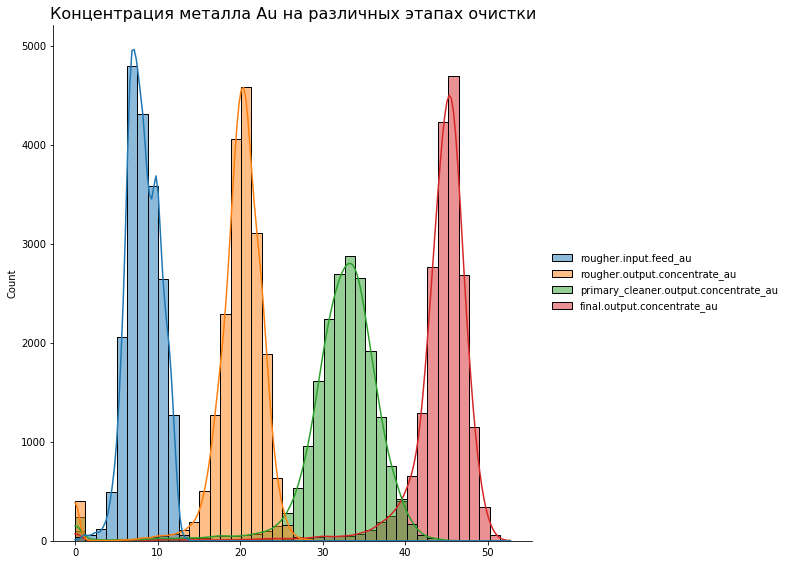

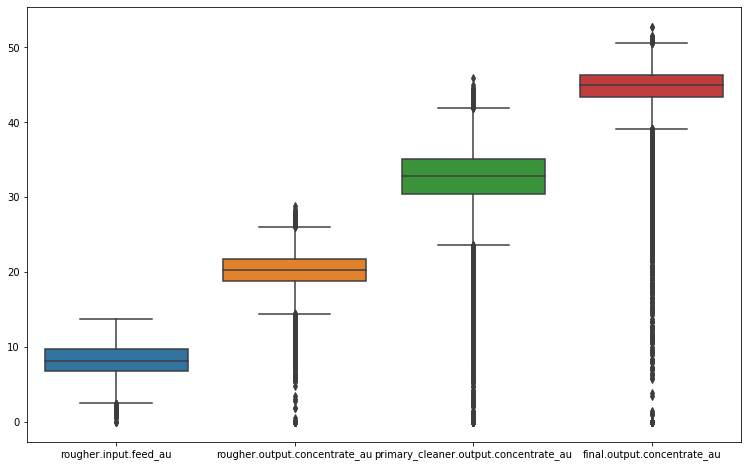

In [26]:
concentrate_plot(elements['золото'])

Видим - концентрация золота с каждым этапом очистки увеличивается. Наименьшая концентрация золота на этапе rougher.input.feed_au (сырье), а самый высокий на финальном этапе final.output.concentrate_au, т.е., после того, как концентрат прошел все стадии очистки. В данных присутствуют выбросы (на всех этапах очистки).

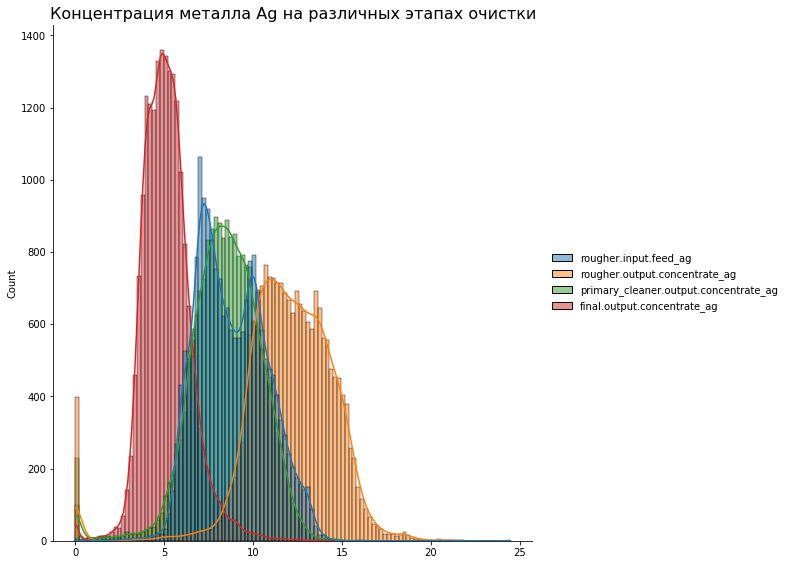

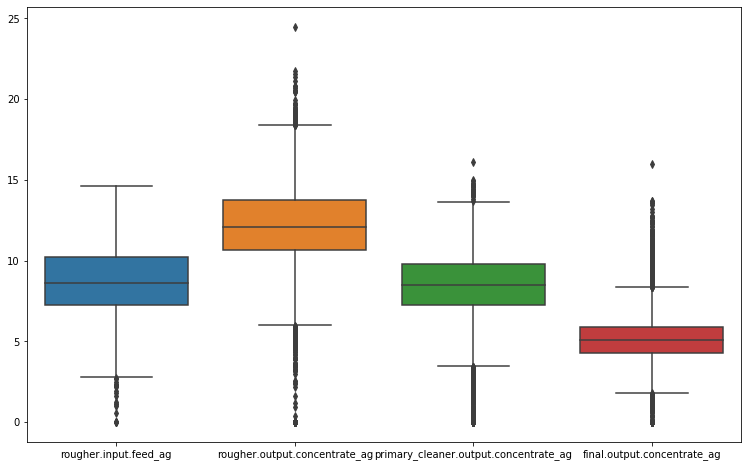

In [27]:
# Посмотрим на концентрацию других металлов
concentrate_plot(elements['серебро'])


В отличии от золота, концентрация серебра с каждым этапом очистки уменьшается, а на финальном этапе показатель концентрации серебра даже ниже, чем на первом этапе очистки. Максимальную концентрацию серебра мы видим после второго этапа очистки. В данных присутствуют выбросы.

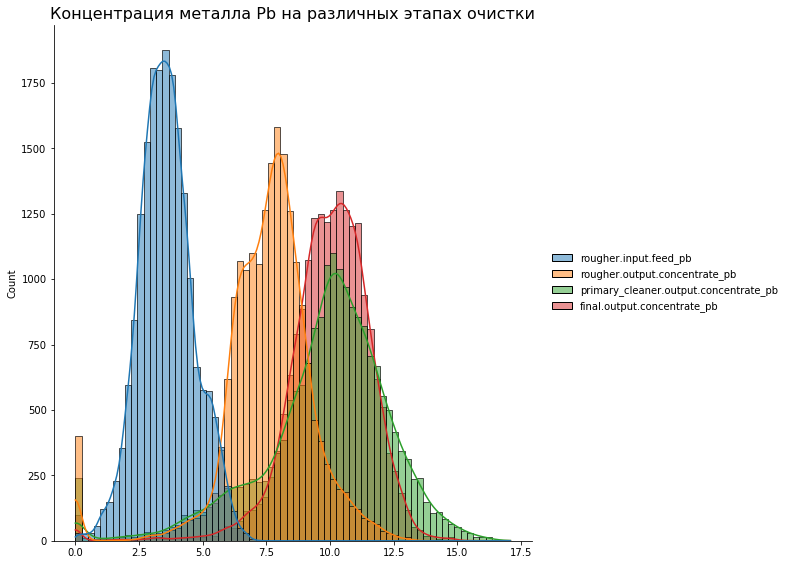

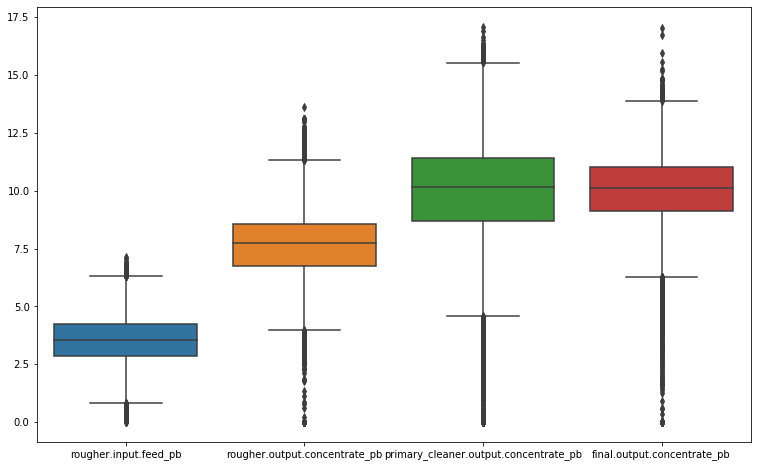

In [28]:
concentrate_plot(elements['свинец'])

Концентрация свинца на всех этапах возрастает. На финальной стадии наблюдается уменьшение разброса значений. Имеем выбросы.

### Анализ гранул сырья на обучающей и тестовой выборках
Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

Посмотрим на распределения обучающей и тестовой выборки

In [29]:
rougher_input_feed_size = pd.concat([train_copy['rougher.input.feed_size'], 
                                     test_copy['rougher.input.feed_size']], axis=1) 
rougher_input_feed_size.columns = ['train', 'test']
rougher_input_feed_size.describe()

,train,test
count,14149.000000,5289.000000
mean,60.239856,55.951097
std,23.005310,19.081758
min,9.659576,0.046369
25%,48.966751,43.906347
50%,55.269784,50.841029
75%,66.007526,62.431047
max,484.967466,392.494040


Text(0.5, 1, 'Распределение размеров гранул сырья на обучающей и тестовой выборках (сырье)')

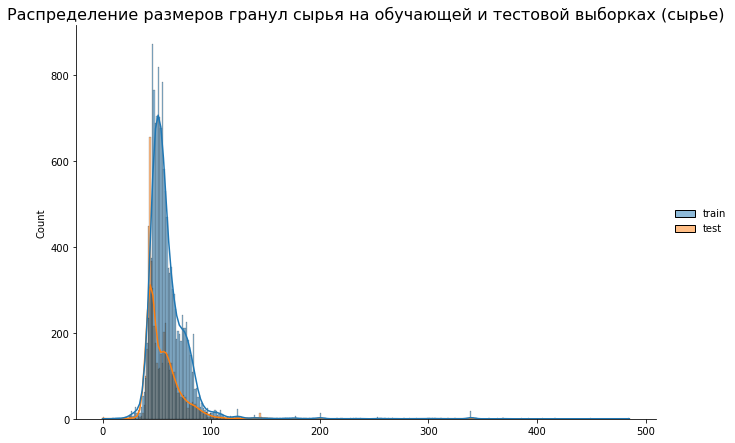

In [30]:
sns.displot(rougher_input_feed_size, legend=True, kde=True, height=6, aspect=1.5)
plt.title('Распределение размеров гранул сырья на обучающей и тестовой выборках (сырье)', fontsize=16)

In [31]:
primary_cleaner_input_feed_size = pd.concat([train_copy['primary_cleaner.input.feed_size'], 
                                     test_copy['primary_cleaner.input.feed_size']], axis=1) 
primary_cleaner_input_feed_size.columns = ['train', 'test']
primary_cleaner_input_feed_size.describe()

,train,test
count,14149.000000,5290.000000
mean,7.322310,7.266339
std,0.614062,0.610219
min,1.080000,5.650000
25%,6.960000,6.890000
50%,7.290000,7.250000
75%,7.700000,7.600000
max,10.470000,15.500000


Text(0.5, 1, 'Распределение размеров гранул сырья на обучающей и тестовой выборках (первичная очистка)')

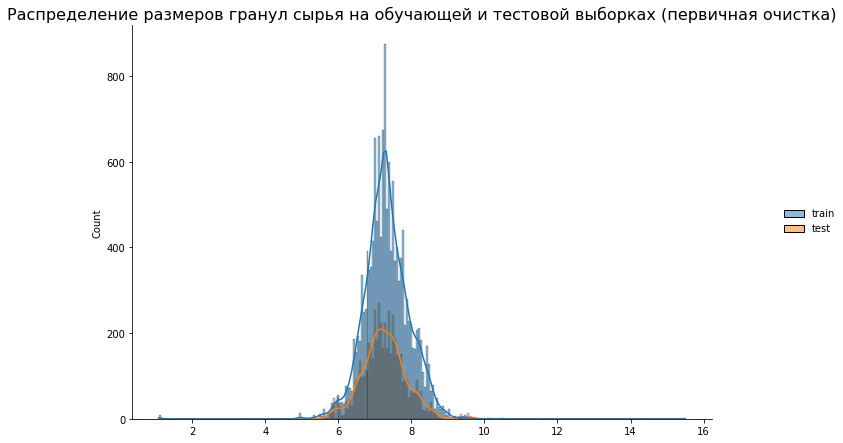

In [32]:
sns.displot(primary_cleaner_input_feed_size, legend=True, kde=True, height=6, aspect=1.5)
plt.title('Распределение размеров гранул сырья на обучающей и тестовой выборках (первичная очистка)', fontsize=16)

Размеры гранул примерно одинаково распределены на обучающей и тестовой выборках. Можем предположит, что те незначительные различия, которые все-таки имеются, не будет негативно влиять на работу модели.

 В данном случае желательно было использовать параметр "density=True" в методе ".hist()". Так бы нам удалось перейти от количества к доле.


### Анализ суммарной концентрации всех металлов на разных стадиях

Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Заметили аномальные значения в суммарном распределении или нет? Если они есть, стоит ли их удалять из обеих выборок? Опишите выводы и удалите аномалии.

Из датафрейма full_copy отберем те признаки, которые характеризуют концентрацию веществ (Au, Ag, Pb) на разных стадиях. Для каждой стадии посчитаем общую концентрацию всех металлов.

In [35]:
first = 'rougher.input.feed_'
second = 'rougher.output.concentrate_'
third = 'primary_cleaner.output.concentrate_'
fourth = 'final.output.concentrate_'

full_copy['сырье'] = full_copy[[first+'au', first+'ag', first+'pb']].sum(axis=1)
full_copy['черновой концентрат'] = full_copy[[second+'au', second+'ag', second+'pb']].sum(axis=1)
full_copy['концентрат после очистки'] = full_copy[[third+'au', third+'ag', third+'pb']].sum(axis=1)
full_copy['финальный концентрат'] = full_copy[[fourth+'au', fourth+'ag', fourth+'pb']].sum(axis=1)

In [36]:
full_copy[['сырье', 'черновой концентрат', 'концентрат после очистки', 'финальный концентрат']].describe()

,сырье,черновой концентрат,концентрат после очистки,финальный концентрат
count,19439.000000,19439.000000,19439.000000,19439.000000
mean,20.646120,39.373032,50.372125,59.223721
std,4.480027,6.863389,7.628095,6.095138
min,0.030000,0.000000,0.000000,0.000000
25%,17.252879,38.394639,50.053899,59.298323
50%,20.141216,40.312648,51.909156,60.306921
75%,23.797381,42.365102,53.386898,61.096667
max,33.498784,55.568687,60.269003,64.968881


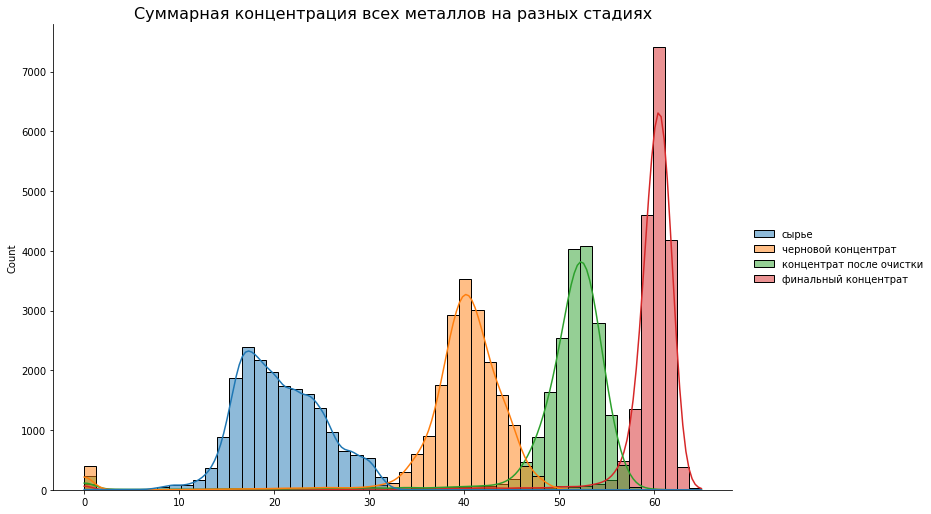

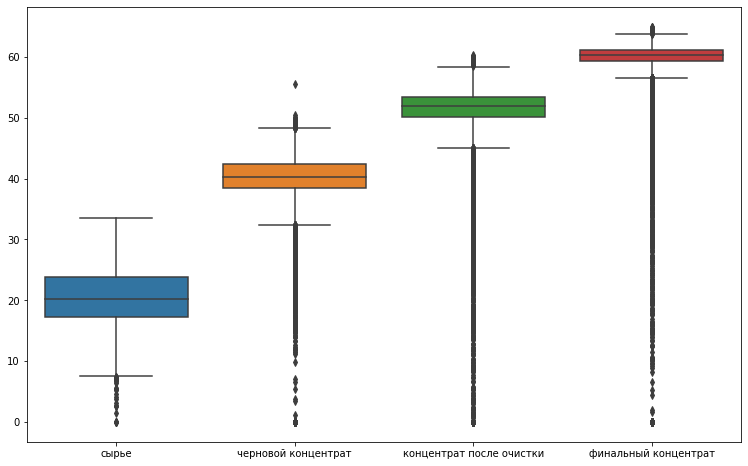

In [37]:
stage_cols = ['сырье', 'черновой концентрат', 'концентрат после очистки', 'финальный концентрат']
    
concentrate = full_copy[stage_cols]    
    
sns.displot(full_copy[stage_cols], 
            legend=True, 
            kde=True, 
            height=7, 
            aspect=1.5)
    
plt.title('Суммарная концентрация всех металлов на разных стадиях', fontsize=16)
    
plt.figure(figsize=(12.8,8))
plt.xticks(rotation=0)
sns.boxplot(data=full_copy[stage_cols])

Для успешной работы модели нам следует удалить выбросы на каждом этапе очистки.<br>
Для некоторых объектов суммарное концентрация всех металлов на этапах черновой концентрат, концентрат после очистки и финальный концентрат составляет 0. Такие объекты удалим, так как они не несут никакого смысла и могут негативно повлиять на работу модели.

In [40]:
for col in stage_cols:
    print(col, '(нули):', len(full_copy[full_copy[col] == 0]))
    print(col, '(меньше 1):', len(full_copy[full_copy[col] < 1]))
    print()

сырье (нули): 0
сырье (меньше 1): 5

черновой концентрат (нули): 394
черновой концентрат (меньше 1): 399

концентрат после очистки (нули): 108
концентрат после очистки (меньше 1): 229

финальный концентрат (нули): 98
финальный концентрат (меньше 1): 99



In [41]:
# Обновим копию исходных данных и оставим там только те объекты, где суммарная концентрация металлом не меньше 1.

full_clean = full_copy[
    (full_copy['сырье'] >  1) & 
    (full_copy['черновой концентрат'] > 1) & 
    (full_copy['концентрат после очистки'] > 1) & 
    (full_copy['финальный концентрат'] > 1)
]

full_clean.shape

(18721, 91)

Контроль

Text(0.5, 1, 'Суммарная концентрация всех металлов на разных стадиях (обновленный датасет)')

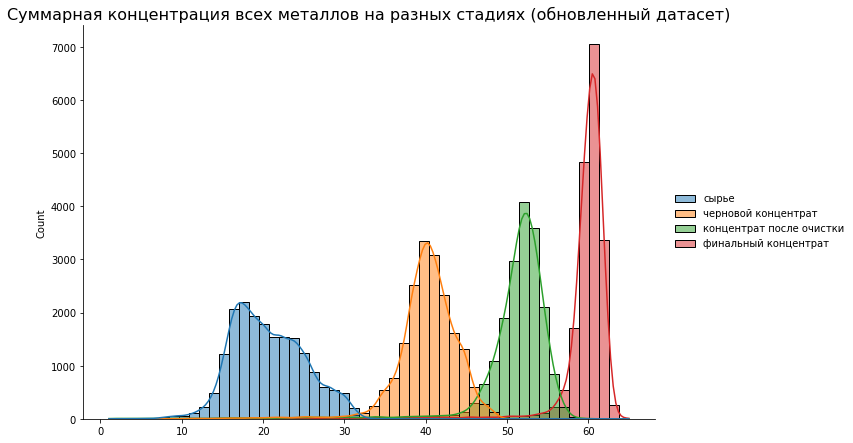

In [42]:

sns.displot(full_clean[['сырье', 'черновой концентрат', 
                       'концентрат после очистки', 'финальный концентрат']], 
            legend=True, 
            kde=True, 
            height=6, 
            aspect=1.5)
plt.title('Суммарная концентрация всех металлов на разных стадиях (обновленный датасет)', fontsize=16)

In [43]:
full_clean[['сырье', 'черновой концентрат', 'концентрат после очистки', 'финальный концентрат']].describe()

,сырье,черновой концентрат,концентрат после очистки,финальный концентрат
count,18721.000000,18721.000000,18721.000000,18721.000000
mean,20.650243,40.212048,50.964122,59.537313
std,4.431189,3.823193,5.209286,4.263810
min,2.560855,1.137053,1.037408,1.685441
25%,17.238008,38.537325,50.123640,59.307366
50%,20.136186,40.381394,51.916945,60.303141
75%,23.787611,42.411418,53.362292,61.086650
max,33.498784,55.568687,60.106566,64.968881


Из таблицы видно, что нам удалось уменьшить разброс данных, минимальные значения на каждых этапах превысили 1. А также изменился показатель стандартного отклонения std.

In [45]:
# Удалим ненужное

train_clean = train_copy[train_copy['date'].isin(full_clean['date'])]
test_clean = test_copy[test_copy['date'].isin(full_clean['date'])]

train_clean.dropna(inplace=True) # удаляем пропуски
test_clean.dropna(inplace=True)  # удаляем пропуски

print('train', train_clean.shape)
print('test', test_clean.shape)

train (13598, 55)
test (5074, 55)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


# Вывод (шаг 2)
Мы пронаблюдали как изменяется концентрация металлов Au, Ag, Pb на различных этапах очистки. Делаем вывод, что концентрация металлов меняется от этапов очистки. Концентрация серебра от этапа к этапу падает, когда концентрация золота растёт. Концентрация свинца растёт на первых 3-х этапах. На финальном этапе медиана концентрации свинца сопадает с предыдущим шагом, а вот границы разброса значений сужаются. На всех этапах присутствуют выбросы.   Посмотрели на  размеры гранул на обучающей и тестовой выборках и убедились, что размеры гранул примерно одинаково распределены в обоих выборках. Обнаружили и удалили аномалии (нули) из всех датасетов.

## Модель

### Функция для расчета sMAPE
Напишите функцию для вычисления итоговой sMAPE

In [47]:
def sMAPE(target, predictions):
    numerator = abs(predictions - target)
    denominator = (abs(target) + abs(predictions)) / 2
    summ = (numerator / denominator).sum()

    smape = 1 / len(target) * summ * 100
    return smape

def sMAPE_final(smape_rougher, smape_final):
    smape_final = 0.25 * smape_rougher + 0.75 * smape_final
    return smape_final

### Обучение и выбор модели


In [48]:

target_rougher_train = train_clean['rougher.output.recovery']
target_final_train = train_clean['final.output.recovery']
features_train = train_clean.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)


target_rougher_test = test_clean['rougher.output.recovery']
target_final_test = test_clean['final.output.recovery']
features_test = test_clean.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)

In [49]:
print('features_train', features_train.shape)
print('features_test', features_test.shape)

features_train (13598, 52)
features_test (5074, 52)


In [50]:
# Масштабируем наши признаки

numeric = features_train.columns
scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [52]:
features_train.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,-0.177039,0.374634,-0.128322,0.283117,-0.446599,-0.299217,-0.428651,-0.810462,-0.433391,-0.276266,...,-1.050803,-0.476117,-0.642255,-0.759903,-1.178724,-0.384014,-0.864161,-0.430466,-0.960817,-2.679757
1,-0.214782,0.424724,-0.128322,0.320132,-0.241337,-0.355833,-0.241880,-0.321604,-0.238985,-0.295026,...,-1.055140,-0.535469,-0.670620,-0.702030,-1.159205,-0.432692,-0.880625,-0.433308,-0.987551,-2.516067
2,-0.261469,0.728935,-0.128322,0.289790,-0.043863,-0.330060,-0.055721,-0.343534,-0.045404,-0.340007,...,-1.051125,-0.476765,-0.677787,-0.698642,-1.153765,-0.431623,-0.875573,-0.431657,-0.982254,-2.560408
3,-0.301453,0.730682,-0.128322,0.304361,-0.056210,-0.357163,-0.053644,-0.316023,-0.058052,-0.335898,...,-1.047328,-0.444019,-0.661313,-0.699673,-1.171039,-0.407346,-0.881914,-0.424969,-0.986293,-2.521715
4,-0.411939,0.907081,-0.128322,0.339316,-0.045547,-0.301016,-0.047713,-0.335124,-0.063427,-0.340530,...,-1.048955,-0.423967,-0.670138,-0.697283,-1.178712,-0.472391,-0.896326,-0.427528,-0.987849,-2.562283


In [55]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

random_state = 123
cv = 5


models = [DecisionTreeRegressor(random_state = random_state), 
          RandomForestRegressor(random_state=random_state), 
          LinearRegression()]

In [57]:
results_cross_val = []

for model in models: 
    
    scorer = make_scorer(sMAPE, greater_is_better=False) 
    
    cross_val_score_rougher = cross_val_score(model, 
                                              features_train, 
                                              target_rougher_train, 
                                              cv=cv, scoring=scorer).mean()
    cross_val_score_final = cross_val_score(model, 
                                            features_train, 
                                            target_final_train, 
                                            cv=cv, scoring=scorer).mean()

    results_cross_val.append({'model name': model.__class__.__name__, 
                              'cross_val_score_rougher': cross_val_score_rougher, 
                              'cross_val_score_final': cross_val_score_final}) 
              
pd.DataFrame(results_cross_val)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

,model name,cross_val_score_rougher,cross_val_score_final
0,DecisionTreeRegressor,-9.569796,-15.898333
1,RandomForestRegressor,-6.751332,-10.462878
2,LinearRegression,-7.281616,-11.026030


<div class="alert alert-block alert-success">
<b>Успех:</b> Скорер был определен правильно.
</div>

Модель случайного леса вырывается вперёд среди своих конкурентов

In [62]:
%%time 
results = []

for depth in range(1,5):
    
    for estimator in range(10, 21, 5):
        
        model = RandomForestRegressor(random_state=random_state, 
                                       n_estimators=estimator, 
                                       max_depth=depth)
        
        scorer = make_scorer(sMAPE, greater_is_better=False) 
    
        cross_val_score_rougher = cross_val_score(model, features_train, target_rougher_train, cv=cv, scoring=scorer).mean()
        cross_val_score_final = cross_val_score(model, features_train, target_final_train, cv=cv, scoring=scorer).mean()

        smape_final_result = sMAPE_final(cross_val_score_rougher, cross_val_score_final)

        results.append({'model name': model.__class__.__name__, 
                        'Hyperparameters': {'random_state': random_state, 
                                            'n_estimators': estimator, 
                                            'max_depth':depth}, 
                        'smape_final_result': smape_final_result})

pd.DataFrame(results).style.highlight_max(color = 'lightgreen', axis = 0)

CPU times: user 2min 31s, sys: 127 ms, total: 2min 31s
Wall time: 2min 31s


,model name,Hyperparameters,smape_final_result
0,RandomForestRegressor,"{'random_state': 123, 'n_estimators': 10, 'max_depth': 1}",-9.05051
1,RandomForestRegressor,"{'random_state': 123, 'n_estimators': 15, 'max_depth': 1}",-9.05429
2,RandomForestRegressor,"{'random_state': 123, 'n_estimators': 20, 'max_depth': 1}",-9.00978
3,RandomForestRegressor,"{'random_state': 123, 'n_estimators': 10, 'max_depth': 2}",-8.56631
4,RandomForestRegressor,"{'random_state': 123, 'n_estimators': 15, 'max_depth': 2}",-8.54308
5,RandomForestRegressor,"{'random_state': 123, 'n_estimators': 20, 'max_depth': 2}",-8.52996
6,RandomForestRegressor,"{'random_state': 123, 'n_estimators': 10, 'max_depth': 3}",-8.35943
7,RandomForestRegressor,"{'random_state': 123, 'n_estimators': 15, 'max_depth': 3}",-8.36779
8,RandomForestRegressor,"{'random_state': 123, 'n_estimators': 20, 'max_depth': 3}",-8.34491
9,RandomForestRegressor,"{'random_state': 123, 'n_estimators': 10, 'max_depth': 4}",-8.41238


Лучшими гиперпараметрами для данной модели оказались n_estimators = 20 и max_depth = 3

<div class="alert alert-block alert-info">
<b>Совет: </b> Можно было подобрать парамтеры ко всем моделям. Нет гарантии, что решающее дерево после подбора парамтеров не покажет качества лучше, чем случайный лес.
</div>

### Проверка модели на тестовой выборке

In [63]:
# Обучим модель с лучшими гиперапарметрами и исследуем её работу на тесте

model_final = RandomForestRegressor(random_state=random_state, 
                                       n_estimators=20, 
                                       max_depth=3)

model_final.fit(features_train, target_rougher_train)
predictions_r = model_final.predict(features_test)

model_final.fit(features_train, target_final_train)
predictions_f = model_final.predict(features_test)


In [65]:
smape_r = sMAPE(target_rougher_test, predictions_r)
smape_f = sMAPE(target_final_test, predictions_f)

print('Итоговое sMAPE:', sMAPE_final(smape_r, smape_f))

Итоговое sMAPE: 7.04350757964738


### Проверка модели на адекватность

In [67]:
#можно использовать регрессор DummyRegressor из библиотеки Skelarn для оценки адекватности
from sklearn.dummy import DummyRegressor

dummy_regr = DummyRegressor(strategy='mean')

dummy_regr.fit(features_train, target_rougher_train)
predictions_r_dummy = dummy_regr.predict(features_test)

dummy_regr.fit(features_train, target_final_train)
predictions_f_dummy = dummy_regr.predict(features_test)

In [69]:
smape_r_dummy = sMAPE(target_rougher_test, predictions_r_dummy)
smape_f_dummy = sMAPE(target_final_test, predictions_f_dummy)

print('Итоговое sMAPE', sMAPE_final(smape_r_dummy, smape_f_dummy))

Итоговое sMAPE 7.684349886589512


Обученная модель показала себя чуть лучше константной примерно на 0.7%. 

# Вывод(шаг3)

Были написаны функции для расчёта метрики sMAPE и итоговой sMAPE. Далее посмотрели , как обучились три разных модели и решили, что модель случайного леса обучилась лучше остальных. Далее для данной модели были подобраны оптимальные гиперапаметры глубина (depth=3) и соседи(n_estimators=20), с которыми она показала приемлемые результаты на тестовой выборке, где с вероятностью 7% может ошибиться, тогда как константная - с вероятностью 7.7%. 

# Общий вывод
Мы закончили исследование модели, которая предсказывает коэффициент восстановления золота из золотосодержащей руды.<br>
Для этого мы выполнили подготовку данных, а именно - обработали пропуски, привели данные к нужному типу, сделали проверку на дубликаты. оставили в обучающей и тестовой выборках одинаковое к-во признаков и убедились, что они не коррелируют с целевыми признаками. Утвердили правильность расчёта обогащения.<br>

На этапе анализа данных мы исследовали концентрацию металлов Au, Ag, Pb на различных этапах очистки. Концентрация каждого из металлов меняется в зависимости от этапа очистки: концентрация золота постепенно увеличивается с каждым этапом, серебра — падает, а свинца растёт на первых 3-х этапах. На обучающей и тестовой выборках проанализировали размеры гранул и убедились , что они примерно совпадают в своих распределениях. Далее анализировали суммарную концентрацию всех металлов на разных стадиях,обнаружили и удалили нулевые значения из датасетов. <br>

После подготовительного и аналитического этапа мы реализовали функцию для подсчёта метрики качества sMAPE. Сравнили эффективность 3х моделей (DecisionTreeRegressor, RandomForestRegressor, LinearRegression) и выбрали RandomForestRegressor в качестве эталона для данной задачи с гиперпараметрами  n_estimators = 20 и max_depth = 3. На тестовой выборке ошибка модели sMAPE составила 7%. После проверки на адекватность константная модель ошибается с приблизительной вероятностью 7.7%.